# DecGene: mapping PPs to combinations of CCF regions
**Fig. 2** and **Fig. 3** in the manuscript

In [1]:
# import libraries
import dask.array as da
from datetime import datetime
import math
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import networkx as nx
import numpy as np
import os
import pandas as pd
from pca_with_missing_values import pca_with_missing_values
import pickle
from PIL import Image, ImageFilter
from scipy import ndimage # for calculating Center-of-mass
from scipy import stats
from scipy.stats import sem
from scipy.optimize import linear_sum_assignment
from scipy.optimize import nnls
from skimage.morphology import binary_dilation
import sklearn.preprocessing
from morans_index import runManyMoranI
from staNMF_ import staNMF
from staNMF.nmf_models import sklearn_nmf

In [2]:
#load reference atlas
areas_atlas = np.load('../data/mouse_coarse_structure_atlas.npy')
mouse_coarse_df = pd.read_pickle('../data/mouse_coarse_df')
mouse_atlas = np.load('../data/mouse_areas_structure_atlas.npy')
mouse_df = pd.read_pickle('../data/mouse_areas_df')

In [4]:
# load/generate reference atlas (CCF 3.0) at fine resolutin
import nrrd

# download annotation array at 100 um
#URL: http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/

# read in annotation array
ann = nrrd.read("../data/annotation_100_2017.nrrd")
arr = ann[0]

# get all unique region numbers (reflects "id" in json file)
region_ids = np.unique(arr)

# process annotation labels into numpy
ccf_fine = np.zeros((len(region_ids),arr.shape[0], arr.shape[1], arr.shape[2])) 
for n in range(len(region_ids)):
    ccf_fine[n] = np.where(arr == region_ids[n], 1, 0)
    
# remove first CCF reference value (which is empty)
ccf_fine = np.delete(ccf_fine,0,0)
region_ids = np.delete(region_ids,0,0)

ccf_fine.shape, region_ids.shape

((669, 132, 80, 114), (669,))

In [8]:
# downsample ccf

ccf_fine_down = ccf_fine

# remove every nth line
def Downsample(_n_line, _target):
    for d in range(3):
        del_list = []
        for i in range(_target.shape[d+1]):
            if (i) % _n_line == 1:
                del_list.append(i)
        _target = np.delete(_target, del_list, axis=d+1)
    return _target

# downsample to get to a small enough value
ccf_fine_down = Downsample(2, ccf_fine_down)

# remove ccf_fine
ccf_fine_down.shape

(669, 66, 40, 57)

In [9]:
# download and load json of structures
# URL: http://api.brain-map.org/api/v2/structure_graph_download/1.json

import json
with open('../data/ccf_fine_labels.json', 'r') as f:
    data = json.load(f)

data = data['msg'][0]
ccf_df = pd.DataFrame(columns=['id', 'atlas_id', 'ontology_id', 'acronym',
                               'name', 'color_hex_triplet', 'graph_order',
                               'st_level', 'hemisphere_id', 'parent_structure_id', 'children'])


# dynamic programming to get all children
def getChildren(_record):
    child_list = []
    
    if len(_record['children']) > 0:
        for d in _record['children']:
            child_list.append(d)
            if len(getChildren(d)) > 0:
                for child in getChildren(d):
                    child_list.append(child)
    
    return child_list

# run algorithm to get all children data
all_children = getChildren(data)


# slush - view id list
id_list = []
for i in range(len(all_children)):
    id_list.append(all_children[i]['id'])
id_list.sort()
id_list

# get into dataframe
for i in range(len(all_children)):
    df_tmp = pd.DataFrame(all_children[i]['children'])
    ccf_df = pd.concat([ccf_df, df_tmp])
ccf_df = ccf_df.reset_index(drop=True)

In [10]:
ccf_df.groupby(['st_level']).count()['id']

st_level
2       9
3       4
4       1
5      13
6      34
7      29
8     382
9     275
10     67
11    507
Name: id, dtype: int64

In [11]:
%%time
# build new CCF region atlas based upon fine-level data
region_ids_expanded = region_ids.copy()
ccf_fine_down_expanded = ccf_fine_down.copy()
zeros = np.zeros((1,ccf_fine_down_expanded.shape[1],ccf_fine_down_expanded.shape[2],ccf_fine_down_expanded.shape[3]))

# loop through each st level, from 12 to 2 in descending order
for i in reversed(range(2,12)):
    
    tmp_df = ccf_df[ccf_df['st_level'] == i]

    # loop through each id
    for j in range(len(tmp_df)):

            # check to see if it has children
            if len(tmp_df.iloc[[j]]['children'].values[0]) > 0:
                
                # check to see if in id list already from annotation_100.nrrd (url: http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/)
                if tmp_df.iloc[[j]]['id'].values[0] not in region_ids_expanded: 
                
                    # add new region id to expanded list of region ids
                    region_ids_expanded = np.append(region_ids_expanded, tmp_df.iloc[[j]]['id'].values[0])

                    # add new region to ccf_fine
                    ccf_fine_down_expanded = np.append(ccf_fine_down_expanded, zeros, axis=0)
                    
                    tmp_index = -1
                    
                else:
                    tmp_index = np.where(region_ids_expanded==tmp_df.iloc[[j]]['id'].values[0])[0][0]
                    

                # loop through each child and add to ccf_fine_down
                for child in tmp_df.iloc[[j]]['children'].values[0]:

                    # check to see if children are in expanded region ids; if so, add to ccf_fine
                    try:
                        ccf_fine_down_expanded[tmp_index] += ccf_fine_down_expanded[np.where(region_ids_expanded==child['id'])[0][0]]
                    except:
                        pass

CPU times: user 6.46 s, sys: 14.4 s, total: 20.9 s
Wall time: 21.6 s


In [12]:
ccf_fine_down.shape, ccf_fine_down_expanded.shape, region_ids.shape, region_ids_expanded.shape

((669, 66, 40, 57), (868, 66, 40, 57), (669,), (868,))

In [13]:
# count how many regions without CCF values
countzero = 0
for i in range(len(ccf_fine_down_expanded)):
    if np.sum(ccf_fine_down_expanded[i]) == 0:
        countzero += 1
        
print("Zero value regions", countzero)

Zero value regions 61


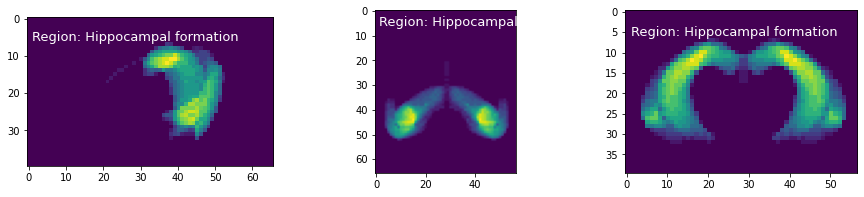

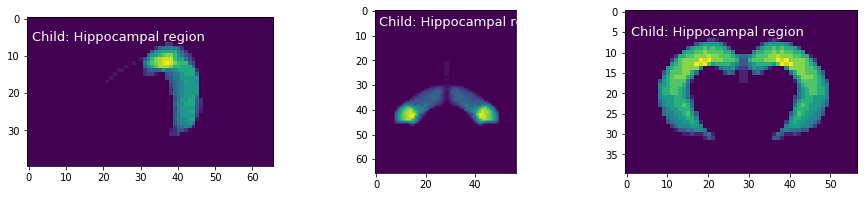

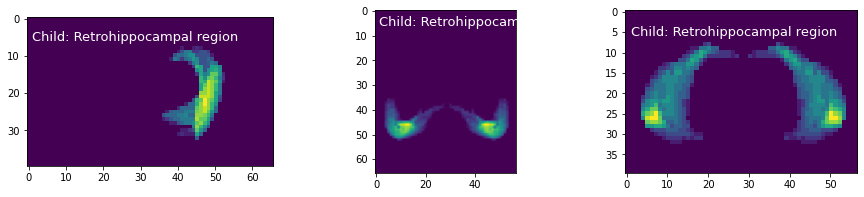

In [14]:
#### Visualize
region_id_tst = ccf_df[ccf_df['name']=="Hippocampal formation"]['id'].values[0]
index = np.where(region_ids_expanded==region_id_tst)[0][0]
children = []
children_names = []
for child in ccf_df[ccf_df['id']==region_id_tst]['children'].values[0]:
    child_tmp = np.where(region_ids_expanded==child['id'])[0][0]
    children.append(child_tmp)
    children_names.append(ccf_df[ccf_df['id']==child['id']]['name'].values[0])
    
name = ccf_df[ccf_df['id']==region_id_tst]['name'].values[0]

np.sum(ccf_fine_down[np.where(region_ids==1089)[0][0]])
    
for i in range(1):
    _, (a, b, c) = plt.subplots(1, 3, figsize=(15, 3))
    a.imshow(np.mean(ccf_fine_down_expanded[index,:, :, :], 2).T)
    b.imshow(np.mean(ccf_fine_down_expanded[index,:, :, :], 1))
    c.imshow(np.mean(ccf_fine_down_expanded[index,:, :, :], 0))
    a.text(1, 6, 'Region: {}'.format(name), color='w', fontsize=13)
    b.text(1, 6, 'Region: {}'.format(name), color='w', fontsize=13)
    c.text(1, 6, 'Region: {}'.format(name), color='w', fontsize=13)
    
for i in range(1):
    _, (a, b, c) = plt.subplots(1, 3, figsize=(15, 3))
    a.imshow(np.mean(ccf_fine_down_expanded[children[0],:, :, :], 2).T)
    b.imshow(np.mean(ccf_fine_down_expanded[children[0],:, :, :], 1))
    c.imshow(np.mean(ccf_fine_down_expanded[children[0],:, :, :], 0))
    a.text(1, 6, 'Child: {}'.format(children_names[0]), color='w', fontsize=13)
    b.text(1, 6, 'Child: {}'.format(children_names[0]), color='w', fontsize=13)
    c.text(1, 6, 'Child: {}'.format(children_names[0]), color='w', fontsize=13)

for i in range(1):
    _, (a, b, c) = plt.subplots(1, 3, figsize=(15, 3))
    a.imshow(np.mean(ccf_fine_down_expanded[children[1],:, :, :], 2).T)
    b.imshow(np.mean(ccf_fine_down_expanded[children[1],:, :, :], 1))
    c.imshow(np.mean(ccf_fine_down_expanded[children[1],:, :, :], 0))
    a.text(1, 6, 'Child: {}'.format(children_names[1]), color='w', fontsize=13)
    b.text(1, 6, 'Child: {}'.format(children_names[1]), color='w', fontsize=13)
    c.text(1, 6, 'Child: {}'.format(children_names[1]), color='w', fontsize=13)
    
if len(children) > 2:
    for i in range(1):
        _, (a, b, c) = plt.subplots(1, 3, figsize=(15, 3))
        a.imshow(np.mean(ccf_fine_down_expanded[children[2],:, :, :], 2).T)
        b.imshow(np.mean(ccf_fine_down_expanded[children[2],:, :, :], 1))
        c.imshow(np.mean(ccf_fine_down_expanded[children[2],:, :, :], 0))
        a.text(1, 6, 'Child: {}'.format(children_names[2]), color='w', fontsize=13)
        b.text(1, 6, 'Child: {}'.format(children_names[2]), color='w', fontsize=13)
        c.text(1, 6, 'Child: {}'.format(children_names[2]), color='w', fontsize=13)

In [15]:
# load PPs
tmp = np.load("../output/DecGene_final_11_PPs.npz")
PPs_3d = tmp['PPs_3d']
print(PPs_3d.shape)

# load PCA PPs
tmp = np.load('../output/PCA_final_11_PPs.npz')
PPs_PCA_3d = tmp['PPs_3d']
PPs_PCA_2d = tmp['PPs']
print(PPs_PCA_3d.shape, PPs_PCA_2d.shape)

# load PCA + Kmeans
clusters_kmeans_PCA = np.load('../output/PCA_clusters_kmeans_2022_11_29.npy')
print(clusters_kmeans_PCA.shape)

# load PCA + hier 
clusters_hier_PCA = np.load('../output/PCA_clusters_hier_2022_11_29.npy')
print(clusters_hier_PCA.shape)

# load DG PPs + hier
clusters_hier = np.load('../output/DecGene_clusters_hier_2022_11_22.npy')
print(clusters_hier.shape)

(11, 66, 40, 57)
(11, 66, 40, 57) (11, 55954)
(11, 66, 40, 57)
(11, 66, 40, 57)
(11, 66, 40, 57)


### create bubble chart
**Fig. 2** in manuscript

In [16]:
# get ccf and PPs into support
support = np.sum(ccf_fine_down_expanded, 0) > 0
support2 = np.sum(areas_atlas, 0) > 0
ccf_2d = ccf_fine_down_expanded[:,support]
PPs_2d = PPs_3d[:,support]
ccf_2d.shape, PPs_2d.shape

((868, 63113), (11, 63113))

In [17]:
# get corr matrix for heat map bubble chart – using unique ontology

# set regions that need level fixes
level_fixes = ['Cerebrum', 'Cerebral cortex', 'Cortical plate','Isocortex', 'Olfactory areas',
               'Hippocampal formation', 'Striatum','Cerebellum','Cerebellar cortex',
               'Midbrain', 'Medulla', 'Pallidum', 'Pons', 'Thalamus','Cortical subplate',
              'Hypothalamus']

# loop through each region and fix its levels
for region in level_fixes:
    index = ccf_df[ccf_df['name']==region]['id'].values[0]
    a = ccf_df.loc[ccf_df['parent_structure_id'] == index]
    if np.max(a['st_level'].values) > 6:
        ccf_df.loc[ccf_df['parent_structure_id'] == index, 'st_level'] = 6
    
    print(region, ccf_df.loc[ccf_df['parent_structure_id'] == index]['st_level'].values)

# create dataframe subset for tracking labels
ccf_medium_df = ccf_df[ccf_df['st_level'] < 7].sort_values(by=['graph_order'])
ccf_medium_df = ccf_medium_df.reset_index(drop=True)

# create new correlation matrix array
corr_mat_bubble = np.zeros((ccf_medium_df.shape[0],len(PPs_3d)))

# loop through each item in the dataframe
for i in range(len(ccf_medium_df['id'].values)):
    for j in range(len(PPs_3d)):
        try:
            pointer = np.where(region_ids_expanded==ccf_medium_df['id'].values[i])[0][0]
            tmp_corr = np.corrcoef(PPs_2d[j], ccf_2d[pointer])[1][0]
            if tmp_corr > 0:
                corr_mat_bubble[i][j] = tmp_corr
            else:
                corr_mat_bubble[i][j] = 0
        except:
            pass

Cerebrum [3 3]
Cerebral cortex [4 5]
Cortical plate [5 5 5]
Isocortex [6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
Olfactory areas [6 6 6 6 6 6 6 6 6 6]
Hippocampal formation [6 6]
Striatum [6 6 6 6]
Cerebellum [5 5]
Cerebellar cortex [6 6 6 6 6]
Midbrain [6 6 6]
Medulla [6 6 6]
Pallidum [6 6 6 6]
Pons [6 6 6]
Thalamus [6 6]
Cortical subplate [6 6 6 6 6 6 6]
Hypothalamus [6 6 6 6 6]


/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [18]:
ccf_medium_df.shape, corr_mat_bubble.shape

((92, 11), (92, 11))

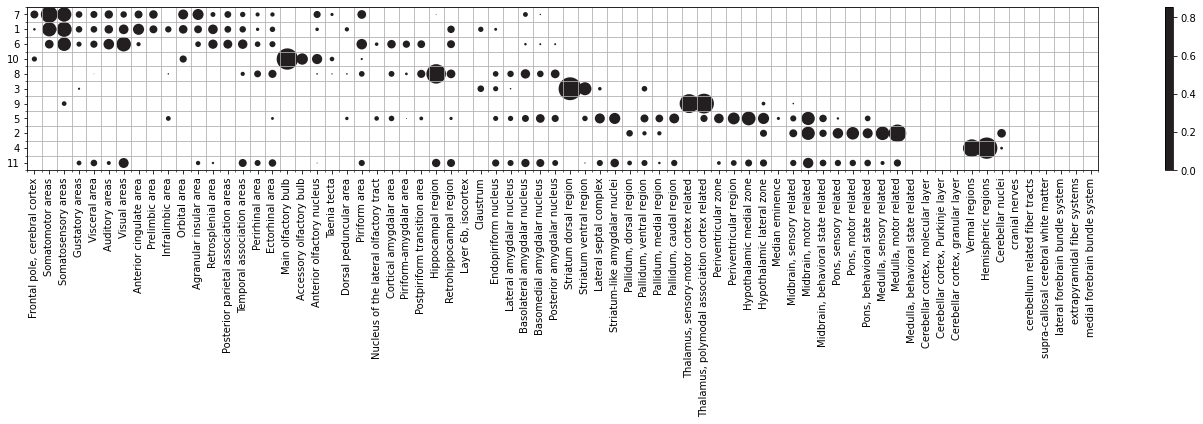

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
# source: URL: https://stackoverflow.com/questions/59381273/heatmap-with-circles-indicating-size-of-population

# manual removals for unnecessary reegions
corr_mat_bubble_edit = corr_mat_bubble.copy()
ccf_medium_df_edit = ccf_medium_df.copy()

# get drop list and indices
regions_to_drop = ['Cerebrum', 'Cerebral cortex', 'Cortical plate','Isocortex', 'Olfactory areas',
                  'Hippocampal formation','Cerebral nuclei', 'Striatum','Brain stem', 'Interbrain',
                  'Hindbrain','Cerebellum','Cerebellar cortex','Midbrain', 'Medulla',
                  'Pallidum', 'Pons', 'Thalamus','Hypothalamus','Cortical subplate']
indices_to_drop = []
for region in regions_to_drop: # get index list to drop
    indices_to_drop.append(np.where(ccf_medium_df_edit['name']==region)[0][0])

# drop unnecessary regions
corr_mat_bubble_edit = np.delete(corr_mat_bubble_edit, indices_to_drop, axis=0)
ccf_medium_df_edit = ccf_medium_df_edit.drop(index=indices_to_drop)
ccf_medium_df_edit = ccf_medium_df_edit.reset_index(drop=True)

# add missing isocortex

# get in data
reshape_order = [6,0,5,9,7,2,8,4,1,3,10][::-1] #[0,1,2,3,4,5,6,7,8,9,10] # [3,1,4,8,2,7,9,6,0,5,10] # to get diagonal view
corrs = corr_mat_bubble_edit[:,reshape_order].T

N = len(PPs_3d)
M = len(ccf_medium_df_edit)
ylabels = [p for p in range(N)]
xlabels = [p for p in range(M)]

x, y = np.meshgrid(np.arange(M), np.arange(N))

fig, ax = plt.subplots(figsize=(M/3,N/1.22/3))
[6,0,1,9] #


#set color
scalar = 256
col_index = 11
color_settings = [[96,57,19], # brown
                  [146,39,143], # purple
                  [33,64,154], # dark blue
                  [28,117,188], # light blue
                  [0,167,157], # blue-green
                  [0,148,68], # green
                  [251,176,64], # yellow
                  [241,90,41], # orange
                  [190,30,45], # dark red
                  [236,0,140], # pink
                  [109,110,113], # grey
                  [35,31,32]] # black
turbo = cm.get_cmap('turbo', 256)
for i in range(len(turbo.colors)):
    turbo.colors[i] = [color_settings[col_index][0]/scalar, color_settings[col_index][1]/scalar,
                       color_settings[col_index][2]/scalar,1]

#create circles
circles = [plt.Circle((j,i), radius=corr**.5/1.2) for corr, j, i in zip(corrs.flat, x.flat, y.flat)]
col = PatchCollection(circles, array=corrs.flatten(), cmap=turbo)
ax.add_collection(col)

ax.set(xticks=np.arange(M), yticks=np.arange(N),
        yticklabels=[x+1 for x in reshape_order],
       xticklabels=[p for p in ccf_medium_df_edit['name']])
ax.set_xticks(np.arange(M+1)-0.5, minor=True)
ax.set_yticks(np.arange(N+1)-0.5, minor=True)
plt.xticks(rotation=90)
ax.grid(which='minor')

fig.colorbar(col)
plt.savefig('../figures/bubble_map.png', transparent=False,dpi=300,bbox_inches='tight')
plt.show()

### create combinations of ccf regions

In [20]:
# get expanded ccf_fine into main flow
ccf_fine_down = ccf_fine_down_expanded

# dilate all regions
ccf_fine_dilated = ccf_fine_down.copy()

for i in range(len(ccf_fine_down)):    
    ccf_fine_dilated[i] = binary_dilation(ccf_fine_down[i])
    
ccf_fine_dilated = ccf_fine_dilated[:,support]

ccf_fine_dilated.shape

(868, 63113)

In [23]:
# %%time
# # create lists of regions that are neighbors

# # create list
# neighbors_2 = []

# # loop through each region
# for i in range(len(ccf_fine_dilated)):
    
#     # choose region a for comparison; binarize and dilate
#     a = np.where(ccf_fine_dilated[i] > 0, 1, -1)
    

#     for j in range(len(ccf_fine_dilated)):
        
#         # choose region b for comparison; binarize and dilate
#         b = ccf_fine_dilated[j]

#         # compare to see if neighbors
#         if np.sum(a==b) > 0 and i != j: # yes neighbor

#             # create combined index for storage (smaller index first)
#             if i < j:
#                 tmp_index = (i,j)
#             else:
#                 tmp_index = (j,i)

#             # append only if index isn't already in list
#             if tmp_index not in neighbors_2:
#                 neighbors_2.append(tmp_index)
                
# # np.save("ccf_fine_down_2_neighbors_2022_12_15", neighbors_2)

neighbors_2 = np.load("../output/ccf_fine_down_2_neighbors_2022_12_15.npy")
print(len(neighbors_2))

22711


In [25]:
# %%time
# # create list of neighbors of 3
# neighbors_3 = []

# # loop through each region
# for i in range(len(ccf_fine_dilated)):
    
#     # choose region a for comparison
#     a = np.where(ccf_fine_dilated[i] > 0, 1, -1)    

#     # loop through already identified neighbors
#     for j in range(len(neighbors_2)):
        
#         # pick indices for existing neighbors
#         index_b = neighbors_2[j][0]
#         index_c = neighbors_2[j][1]

#         # only review neighbors where i isn't already in that neighbor 
#         if index_b != i and index_c != i:
        
#             # choose region b for comparison; binarize and dilate
#             b = np.where(ccf_fine_dilated[index_b] > 0, 1, -2)
#             c = ccf_fine_dilated[index_c]

#             # compare to see if are neighbors
#             if (np.sum(a==b) > 0 and np.sum(b==c) > 0) or (np.sum(a==c) > 0 and np.sum(b==c) > 0): # yes neighbor

#                 # create combined index for storage (smaller index first)
#                 tmp_index = sorted((i,index_b, index_c))
                
# #                 # check to see if that combo is in there already
# #                 if tmp_index not in neighbors_3:
#                 neighbors_3.append(tmp_index)

#     if i % 10 == 0:
#         print("Progress –– region:", i, "; time:", datetime.now().strftime("%H:%M:%S"),
#              "; length of string:", len(neighbors_3))


# # remove unneeded neighbors_3

# # remove duplicates
# neighbors_3 = np.unique(neighbors_3, axis=0).shape

# # get list of parent-child id's
# parent_child = ccf_df[['id', 'parent_structure_id']].values
# parent_child[0]

# del_list = []

# for i in range(len(neighbors_3)):
#     tmp = neighbors_3[i]
#     tmp_ids = [region_ids_expanded[tmp[0]], region_ids_expanded[tmp[1]], region_ids_expanded[tmp[2]]]

#     # remove any parent-child relationships
#     for j in range(len(parent_child)):
#         if parent_child[j][0] in tmp_ids and parent_child[j][1] in tmp_ids:
#             del_list.append(i)            
            
#     if i % 10000 == 0:
#         print("Cleaning –– region:", i, len(del_list))
    
# neighbors_3_cleaned = np.delete(neighbors_3,del_list,axis=0)
# print("original:", len(neighbors_3), "- cleaned:", neighbors_3_cleaned.shape)

# np.save("ccf_fine_down_3_neighbors_2022_12_19", neighbors_3_cleaned)

neighbors_3 = np.load("../output/ccf_fine_down_3_neighbors_2022_12_19.npy")
print(len(neighbors_3))

1834540


In [26]:
%%time
# function to identify max correlation for each PP with up to 3 CCF regions

def maxCorrCCF(_PPs_3d, _neighbors_2, _neighbors_3, _ccf):

    # create variables to be returned
    max_corr_PP = []
    max_index_PP = []

    # get PPs and CCF into 2D in support
    support = np.sum(_ccf, 0) > 0
    ccf_2d = _ccf[:,support]
    PPs_2d = _PPs_3d[:,support]  
    PPs_2d.shape, ccf_2d.shape
    del support, _ccf, _PPs_3d # clear unnecessary variables

    # create atlas of all combined neighbor_2 regions
    combined_atlas_2 = np.zeros((len(_neighbors_2),ccf_2d.shape[1]))
    for i in range(len(neighbors_2)):     # loop through each neighbor combination
        # pull index tuple
        tmp_index = neighbors_2[i]     
        # combine neighbors into one region 
        combined_atlas_2[i] = ccf_2d[tmp_index[0]] + ccf_2d[tmp_index[1]]
        combined_atlas_2[i] = np.where(combined_atlas_2[i] > 1, 1, combined_atlas_2[i]) # keep values equal to 1    

    # loop through each PP
    for i in range(len(PPs_2d)):

        # 1 region: pick max correlation
        tmp_corrs = []
        tmp_index = []
        for j in range(len(ccf_2d)):
            corr_tmp = np.corrcoef(PPs_2d[i], ccf_2d[j])[1][0]
            if corr_tmp > 0:
                tmp_corrs.append(corr_tmp)
            else:
                tmp_corrs.append(0)
            tmp_index.append((j))
        max_corr_PP.append(np.max(tmp_corrs))
        max_index_PP.append(tmp_index[np.argmax(tmp_corrs)]) 

        # 2 regions: check if any neighbor_2 combo has higher corr; if so, replace
        tmp_corrs = []
        tmp_index = []
        for j in range(len(combined_atlas_2)):
            tmp_corrs.append(np.corrcoef(PPs_2d[i], combined_atlas_2[j])[1][0])
            tmp_index.append(_neighbors_2[j])
        if np.max(tmp_corrs) > max_corr_PP[i] + 0.0001:
            max_corr_PP[i] = np.max(tmp_corrs)
            max_index_PP[i] = (tmp_index[np.argmax(tmp_corrs)])

        # 3 regions: check if any neighbor_3 combo has higher corr; if so, replace
        tmp_corrs = []
        tmp_index = []
        for j in range(len(_neighbors_3)):
            # combine neighbors into one region 
            tmp_combo = ccf_2d[_neighbors_3[j][0]] + ccf_2d[_neighbors_3[j][1]] + ccf_2d[_neighbors_3[j][2]]
            tmp_combo = np.where(tmp_combo > 1, 1, tmp_combo) # keep values equal to 1
            tmp_corrs.append(np.corrcoef(PPs_2d[i], tmp_combo)[1][0])
            tmp_index.append(_neighbors_3[j])
        if np.max(tmp_corrs) > max_corr_PP[i] + 0.0001:
            max_corr_PP[i] = np.max(tmp_corrs)
            max_index_PP[i] = (tmp_index[np.argmax(tmp_corrs)])

        # print progress
        print("Progress –– PP:", i, "; time:", datetime.now().strftime("%H:%M:%S"))
        print("Avg. max correlation:", round(np.mean(max_corr_PP),3))
        print("Correlation by PP:", max_corr_PP)
        print("Indices of most correlated CCF regions by PP:", max_index_PP,"\n")

    # print statistics
    print("Avg. max correlation:", round(np.mean(max_corr_PP),3))
    print("Correlation by PP:", max_corr_PP)
    print("Indices of most correlated CCF regions by PP:", max_index_PP,"\n")
    
    # return key values
    return max_corr_PP, max_index_PP

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 6.91 µs


In [27]:
len(neighbors_3)

1834540

In [29]:
# run for DecGene
# max_corr_PP, max_index_PP = maxCorrCCF(PPs_3d, neighbors_2, neighbors_3, ccf_fine_down_expanded)
# np.savez('../output/ccf_corrs/DG_corrs_2022_12_19', max_corr_PP=max_corr_PP, max_index_PP=max_index_PP)

# load saved file
tmp = np.load('../output/ccf_corrs/DG_corrs_2022_12_19.npz',allow_pickle=True)
max_corr_PP = tmp['max_corr_PP'] 
max_index_PP = tmp['max_index_PP']
np.mean(max_corr_PP), max_corr_PP, max_index_PP

(0.7274808122151405,
 array([0.7124576 , 0.8298256 , 0.89362829, 0.91893948, 0.602113  ,
        0.62665212, 0.72581412, 0.66680197, 0.8756081 , 0.77757096,
        0.37287771]),
 array([array([ 14, 240, 853]), array([160, 855, 860]),
        array([ 25, 277, 332]), 854, array([160, 567, 831]),
        array([483, 753, 853]), array([ 82, 483, 853]),
        array([351, 697, 826]), 259, array([242, 490, 747]),
        array([539, 861, 862])], dtype=object))

In [30]:
# # run for PCA
# max_corr_PP_PCA, max_index_PP_PCA = maxCorrCCF(PPs_PCA_3d, neighbors_2, neighbors_3, ccf_fine_down_expanded)
# np.savez('../output/ccf_corrs/PCA_corrs_2022_12_19', max_corr_PP_PCA, max_index_PP_PCA)

# load saved file
tmp = np.load('../output/ccf_corrs/PCA_corrs_2022_12_19.npz',allow_pickle=True)
max_corr_PP_PCA = tmp['arr_0'] 
max_index_PP_PCA = tmp['arr_1']
np.mean(max_corr_PP_PCA), max_corr_PP_PCA, max_index_PP_PCA

(0.6295849762431405,
 array([0.71491715, 0.85916821, 0.85859605, 0.88022518, 0.52689947,
        0.3363062 , 0.40711246, 0.39447786, 0.79380028, 0.57553567,
        0.57839622]),
 array([array([481, 861, 862]), array([483, 697, 853]),
        array([ 25, 332, 371]), 854, array([348, 560, 567]),
        array([750, 753, 823]), array([351, 823, 827]),
        array([348, 831, 853]), array([229, 259, 752]),
        array([242, 259, 863]), array([167, 201, 859])], dtype=object))

In [31]:
# # run for PCA + kmeans
# max_corr_PCA_kmeans, max_index_PCA_kmeans = maxCorrCCF(clusters_kmeans_PCA, neighbors_2, neighbors_3, ccf_fine_down_expanded)
# np.savez('../output/ccf_corrs/PCA_kmeans_2022_12_17', max_corr_PCA_kmeans, max_index_PCA_kmeans)

# load saved file
tmp = np.load('../output/ccf_corrs/PCA_kmeans_2022_12_19.npz',allow_pickle=True)
max_corr_PCA_kmeans = tmp['arr_0'] 
max_index_PCA_kmeans = tmp['arr_1']
np.mean(max_corr_PCA_kmeans), max_corr_PCA_kmeans

(0.6800180473938275,
 array([0.44930683, 0.5354942 , 0.5049877 , 0.9455356 , 0.89218319,
        0.79829674, 0.86436012, 0.39862893, 0.78108421, 0.44870109,
        0.86161991]))

In [32]:
# # run for PCA + hier
# max_corr_PCA_hier, max_index_PCA_hier = maxCorrCCF(clusters_hier_PCA, neighbors_2, neighbors_3, ccf_fine_down_expanded)
# np.savez('../output/ccf_corrs/PCA_hier_2022_12_17', max_corr_PCA_hier, max_index_PCA_hier)

# load saved file
tmp = np.load('../output/ccf_corrs/PCA_hier_2022_12_19.npz',allow_pickle=True)
max_corr_PCA_hier = tmp['arr_0'] 
max_index_PCA_hier = tmp['arr_1']
np.mean(max_corr_PCA_hier), max_corr_PCA_hier

(0.6991933706973978,
 array([0.50789703, 0.90256089, 0.58647768, 0.68128151, 0.47833553,
        0.79851489, 0.88489956, 0.93050525, 0.48957234, 0.89463372,
        0.53644867]))

In [34]:
# run for DG + hier
# max_corr_DG_hier, max_index_DG_hier = maxCorrCCF(clusters_hier, neighbors_2, neighbors_3, ccf_fine_down_expanded)
# np.savez('../output/ccf_corrs/DG_hier_2022_12_17', max_corr_DG_hier, max_index_DG_hier)

# load saved file
tmp = np.load('../output/ccf_corrs/DG_hier_2022_12_19.npz',allow_pickle=True)
max_corr_DG_hier = tmp['arr_0'] 
max_index_DG_hier = tmp['arr_1']
np.mean(max_corr_DG_hier), max_corr_DG_hier

(0.6711164856883544,
 array([0.58834099, 0.84489194, 0.76059266, 0.53076332, 0.74645799,
        0.84548581, 0.60987665, 0.92829194, 0.51910059, 0.37190504,
        0.63657443]))

In [38]:
# print summary of optimal PP combinations for DG

max_corr_input = max_corr_PP
max_index_input = max_index_PP

for p in range(len(max_corr_input)):
    print("PP", p, "- Max corr:", round(max_corr_input[p],3))
    if type(max_index_input[p]) == int:
        i = region_ids_expanded[max_index_input[p]]
        print("ID:", i, "- Name:", ccf_df[ccf_df['id']==i]['name'].values[0],
              "- St level:", ccf_df[ccf_df['id']==i]['st_level'].values[0])
    else:
        for i in range(len(max_index_input[p])):
            id_tmp = region_ids_expanded[max_index_input[p][i]]
            print("ID:", id_tmp, "- Name:", ccf_df[ccf_df['id']==id_tmp]['name'].values[0],
                  "- St level:", ccf_df[ccf_df['id']==id_tmp]['st_level'].values[0])
    print("")


PP 0 - Max corr: 0.712
ID: 28 - Name: Entorhinal area, lateral part, layer 6a - St level: 11
ID: 502 - Name: Subiculum - St level: 8
ID: 315 - Name: Isocortex - St level: 5

PP 1 - Max corr: 0.83
ID: 313 - Name: Midbrain - St level: 5
ID: 519 - Name: Cerebellar nuclei - St level: 5
ID: 1065 - Name: Hindbrain - St level: 3

PP 2 - Max corr: 0.894
ID: 56 - Name: Nucleus accumbens - St level: 8
ID: 583 - Name: Claustrum - St level: 6
ID: 672 - Name: Caudoputamen - St level: 8

PP 3 - Max corr: 0.919
ID: 528 - Name: Cerebellar cortex - St level: 5

PP 4 - Max corr: 0.602
ID: 313 - Name: Midbrain - St level: 5
ID: 1097 - Name: Hypothalamus - St level: 5
ID: 278 - Name: Striatum-like amygdalar nuclei - St level: 6

PP 5 - Max corr: 0.627
ID: 961 - Name: Piriform area - St level: 6
ID: 909 - Name: Entorhinal area - St level: 8
ID: 315 - Name: Isocortex - St level: 5

PP 6 - Max corr: 0.726
ID: 159 - Name: Anterior olfactory nucleus - St level: 6
ID: 961 - Name: Piriform area - St level: 6
ID:

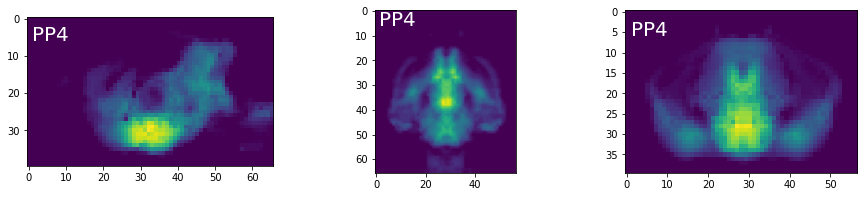

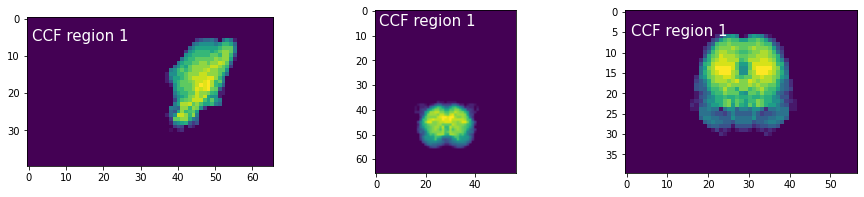

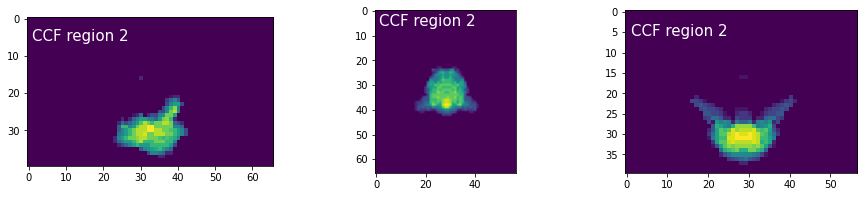

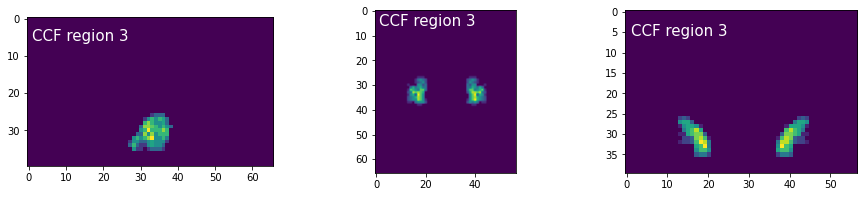

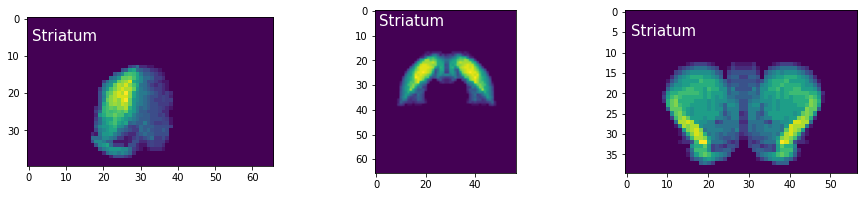

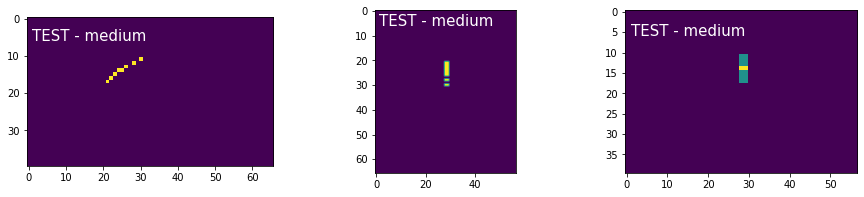

In [39]:
# visualize by PP
pp=4
ind = max_index_PP[pp]

for i in range(1):
    _, (a, b, c) = plt.subplots(1, 3, figsize=(15, 3))
    a.imshow(np.mean(PPs_3d[pp,:, :, :], 2).T)
    b.imshow(np.mean(PPs_3d[pp,:, :, :], 1))
    c.imshow(np.mean(PPs_3d[pp,:, :, :], 0))
    a.text(1, 6, 'PP{}'.format(pp), color='w', fontsize=20)
    b.text(1, 6, 'PP{}'.format(pp), color='w', fontsize=20)
    c.text(1, 6, 'PP{}'.format(pp), color='w', fontsize=20)
    

if type(ind) == int:
    for i in range(1):
        _, (a, b, c) = plt.subplots(1, 3, figsize=(15, 3))
        a.imshow(np.mean(ccf_fine_down[ind,:, :, :], 2).T)
        b.imshow(np.mean(ccf_fine_down[ind,:, :, :], 1))
        c.imshow(np.mean(ccf_fine_down[ind,:, :, :], 0))
        a.text(1, 6, "CCF region 1", color='w', fontsize=15)
        b.text(1, 6, "CCF region 1", color='w', fontsize=15)
        c.text(1, 6, "CCF region 1", color='w', fontsize=15)

else:

    for i in range(1):
        _, (a, b, c) = plt.subplots(1, 3, figsize=(15, 3))
        a.imshow(np.mean(ccf_fine_down[ind[0],:, :, :], 2).T)
        b.imshow(np.mean(ccf_fine_down[ind[0],:, :, :], 1))
        c.imshow(np.mean(ccf_fine_down[ind[0],:, :, :], 0))
        a.text(1, 6, "CCF region 1", color='w', fontsize=15)
        b.text(1, 6, "CCF region 1", color='w', fontsize=15)
        c.text(1, 6, "CCF region 1", color='w', fontsize=15)

    for i in range(1):
        _, (a, b, c) = plt.subplots(1, 3, figsize=(15, 3))
        a.imshow(np.mean(ccf_fine_down[ind[1],:, :, :], 2).T)
        b.imshow(np.mean(ccf_fine_down[ind[1],:, :, :], 1))
        c.imshow(np.mean(ccf_fine_down[ind[1],:, :, :], 0))
        a.text(1, 6, "CCF region 2", color='w', fontsize=15)
        b.text(1, 6, "CCF region 2", color='w', fontsize=15)
        c.text(1, 6, "CCF region 2", color='w', fontsize=15)

    if len(ind) > 2:
        for i in range(1):
            _, (a, b, c) = plt.subplots(1, 3, figsize=(15, 3))
            a.imshow(np.mean(ccf_fine_down[ind[2],:, :, :], 2).T)
            b.imshow(np.mean(ccf_fine_down[ind[2],:, :, :], 1))
            c.imshow(np.mean(ccf_fine_down[ind[2],:, :, :], 0))
            a.text(1, 6, "CCF region 3", color='w', fontsize=15)
            b.text(1, 6, "CCF region 3", color='w', fontsize=15)
            c.text(1, 6, "CCF region 3", color='w', fontsize=15)

    # FOR COMPARISONS
    for i in range(1):
        _, (a, b, c) = plt.subplots(1, 3, figsize=(15, 3))
        a.imshow(np.mean(areas_atlas[11,:, :, :], 2).T)
        b.imshow(np.mean(areas_atlas[11,:, :, :], 1))
        c.imshow(np.mean(areas_atlas[11,:, :, :], 0))
        a.text(1, 6, mouse_coarse_df.iloc[11]['name'], color='w', fontsize=15)
        b.text(1, 6, mouse_coarse_df.iloc[11]['name'], color='w', fontsize=15)
        c.text(1, 6, mouse_coarse_df.iloc[11]['name'], color='w', fontsize=15)

    for i in range(1):
        _, (a, b, c) = plt.subplots(1, 3, figsize=(15, 3))
        a.imshow(np.mean(mouse_atlas[0,:, :, :], 2).T)
        b.imshow(np.mean(mouse_atlas[0,:, :, :], 1))
        c.imshow(np.mean(mouse_atlas[0,:, :, :], 0))
        a.text(1, 6, 'TEST - medium', color='w', fontsize=15)
        b.text(1, 6, 'TEST - medium', color='w', fontsize=15)
        c.text(1, 6, 'TEST - medium', color='w', fontsize=15)


In [40]:
#define_function a function that shows two genes together
def visualize_gene(geneA, template = 0, colorA = 'green', missing_mask = True): 
        
    geneA = np.maximum(geneA, 0)
    
    color_map = {'red':0, 'green':1, 'blue':2}
    colorA = color_map[colorA]    
    if missing_mask:
        geneA = geneA > 0

    _, (a, b, c) = plt.subplots(1, 3, figsize=(15, 5))
    
    x_dim, y_dim, z_dim = geneA.shape
    
    if np.sum(template) == 0:
        template = np.zeros((x_dim, y_dim, z_dim))
    
    out1 = np.zeros((y_dim, z_dim, 3))
    out1[:,:,colorA] = np.sum(geneA, 0)
    out1[:,:,colorA] /= np.max(out1[:,:,colorA])
    
    image = Image.fromarray(np.uint8(cm.gist_earth(np.sum(template,0))*255))
    image = image.filter(ImageFilter.MaxFilter(3))
    image = image.filter(ImageFilter.MinFilter(3))
    image = image.filter(ImageFilter.Kernel((3, 3), (-1, -1, -1, -1, 8,
                                          -1, -1, -1, -1), 1, 0))
    support_x = np.array(image.filter(ImageFilter.FIND_EDGES))[:,:,0]
    
    for rgb_ch in range(3):
        out1[:,:,rgb_ch] = out1[:,:,rgb_ch] + support_x
    c.imshow(out1)
    #plt.colorbar()
    
    out2 = np.zeros((x_dim, z_dim, 3))
    out2[:,:,colorA] = np.sum(geneA, 1)
    out2[:,:,colorA] /= np.max(out2[:,:,colorA])
    
    image = Image.fromarray(np.uint8(cm.gist_earth(np.sum(template,1))*255))
    image = image.filter(ImageFilter.MaxFilter(5))
    image = image.filter(ImageFilter.MinFilter(5))
    image = image.filter(ImageFilter.Kernel((3, 3), (-1, -1, -1, -1, 8,
                                          -1, -1, -1, -1), 1, 0))
    support_y = np.array(image.filter(ImageFilter.FIND_EDGES))[:,:,0]    

    for rgb_ch in range(3):
        out2[:,:,rgb_ch] = out2[:,:,rgb_ch] + support_y
    b.imshow(out2)
    #plt.colorbar()
    
    plt.figure()
    
    out3 = np.zeros((y_dim, x_dim, 3))
    out3[:,:,colorA] = np.sum(geneA, 2).T
    out3[:,:,colorA] /= np.max(out3[:,:,colorA])
    
    image = Image.fromarray(np.uint8(cm.gist_earth(np.sum(template,2))*255))
    image = image.filter(ImageFilter.MaxFilter(3))
    image = image.filter(ImageFilter.MinFilter(3))
    image = image.filter(ImageFilter.Kernel((3, 3), (-1, -1, -1, -1, 8,
                                          -1, -1, -1, -1), 1, 0))
    support_z = np.array(image.filter(ImageFilter.FIND_EDGES))[:,:,0]   
    
    for rgb_ch in range(3):
        out3[:,:,rgb_ch] = out3[:,:,rgb_ch] + support_z.T
    a.imshow(out3)
    
#     a.text(1, 6, 'PP{}'.format(i), color='w', fontsize=30)
#     b.text(1, 6, 'PP{}'.format(i), color='w', fontsize=30)
#     c.text(1, 6, 'PP{}'.format(i), color='w', fontsize=30)
    
    a.axes.get_xaxis().set_visible(False)
    a.axes.get_yaxis().set_visible(False)
    b.axes.get_xaxis().set_visible(False)
    b.axes.get_yaxis().set_visible(False)
    c.axes.get_xaxis().set_visible(False)
    c.axes.get_yaxis().set_visible(False)
    
    plt.show()

In [41]:
# upload template
template = np.flip(np.load('../data/template.npy'),1)

In [42]:
# upsample PPs
_upsample=2
PPs_upsampled = PPs_3d
PPs_upsampled = np.repeat(PPs_upsampled,2,axis=1)
PPs_upsampled = np.repeat(PPs_upsampled,2,axis=2)
PPs_upsampled = np.repeat(PPs_upsampled,2,axis=3)

#upsample mouse_atlas
mouse_atlas_upsampled = ccf_fine_down
mouse_atlas_upsampled = np.repeat(mouse_atlas_upsampled,2,axis=1)
mouse_atlas_upsampled = np.repeat(mouse_atlas_upsampled,2,axis=2)
mouse_atlas_upsampled = np.repeat(mouse_atlas_upsampled,2,axis=3)

PPs_upsampled.shape, mouse_atlas_upsampled.shape

((11, 132, 80, 114), (868, 132, 80, 114))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


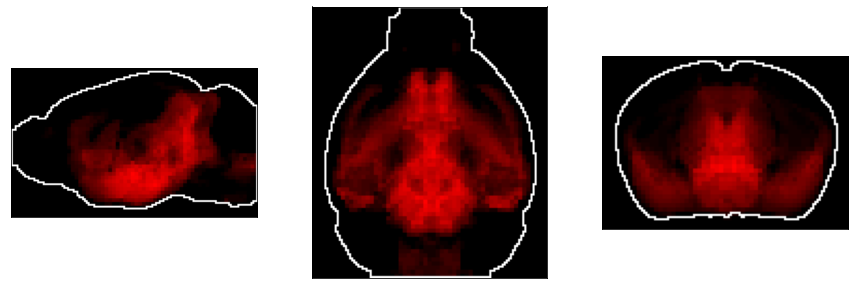

<Figure size 432x288 with 0 Axes>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


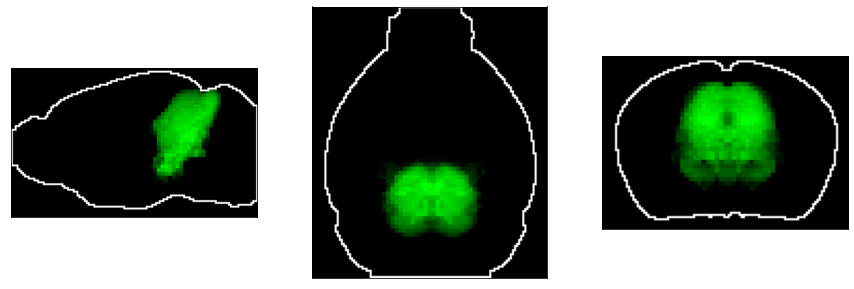

<Figure size 432x288 with 0 Axes>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


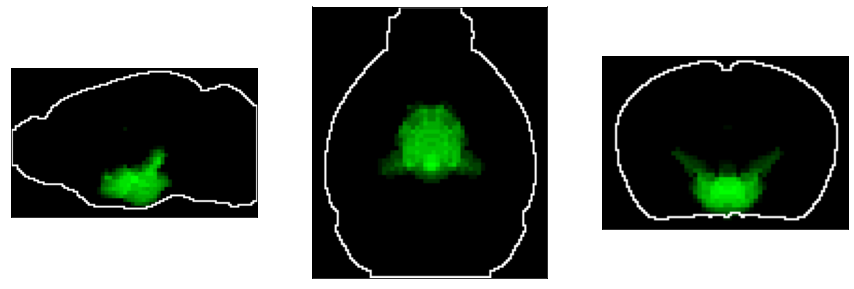

<Figure size 432x288 with 0 Axes>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


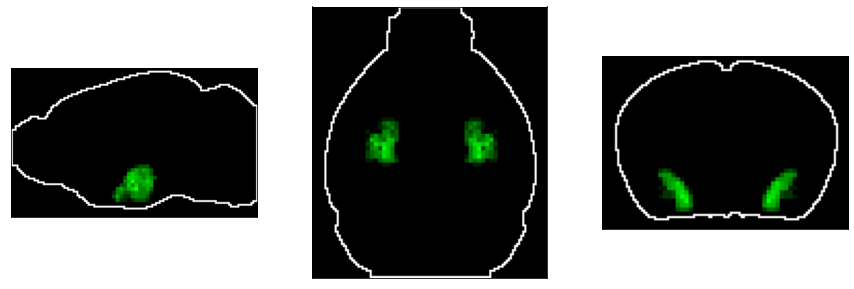

<Figure size 432x288 with 0 Axes>

In [43]:
# visualize with template
# viewer:http://atlas.brain-map.org/atlas?atlas=2#atlas=2&structure=95&resolution=16.75&x=6921&y=3668.9375&zoom=-3&plate=100883813&z=5

pp=4
ind = max_index_PP[pp]

# PP
visualize_gene(geneA=PPs_upsampled[pp], template = template, colorA = 'red')

if type(ind) == int:
    visualize_gene(geneA=mouse_atlas_upsampled[ind], template = template, colorA = 'green')

else:

    # CCF region 1
    visualize_gene(geneA=mouse_atlas_upsampled[ind[0]], template = template, colorA = 'green')

    # CCF region 2
    visualize_gene(geneA=mouse_atlas_upsampled[ind[1]], template = template, colorA = 'green')

    # CCF region 3
    if len(ind) > 2:
        visualize_gene(geneA=mouse_atlas_upsampled[ind[2]], template = template, colorA = 'green')

### bar chart comparing methods
1. DecGene
2. PCA
3. PCA plus hierachical clustering
4. PCA plus kmeans clustering
5. DecGene plus hierachical clustering

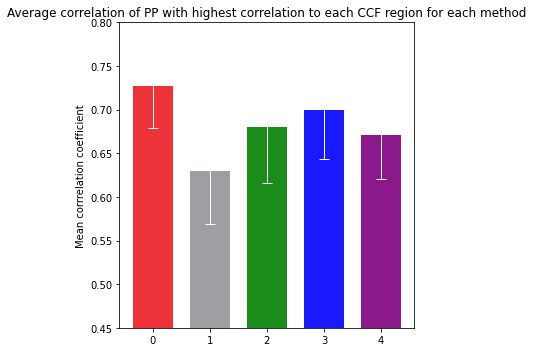

In [44]:
# bar plot of max PPs for each CCF region

from scipy.stats import sem

means = [np.mean(max_corr_PP),
         np.mean(max_corr_PP_PCA),
         np.mean(max_corr_PCA_kmeans),
         np.mean(max_corr_PCA_hier),
         np.mean(max_corr_DG_hier)
        ]

sems = [sem(max_corr_PP), sem(max_corr_PP_PCA), sem(max_corr_PCA_kmeans),
        sem(max_corr_PCA_hier), sem(max_corr_DG_hier)]

# Define labels, positions, bar heights and error bar heights
x_labels = ['DecGene', 'PCA', 'PCA plus hierachical clustering',
            'PCA plus kmeans clustering', 'DecGene plus hierachical clustering']
x_pos = np.arange(len(x_labels))

# Build the plot
plt.figure(figsize=(5,5))
plt.bar(x_pos, means,
       yerr=sems,
       width=.7,
       align='center',
       alpha=0.9,
       color=['#ED1C24', '#939598', 'green', 'blue','purple'],
       ecolor='white',
       error_kw=dict(lw=1, capsize=5, capthick=1))
plt.ylabel('Mean corrrelation coefficient')
plt.ylim(0.45,0.8)
plt.xticks(x_pos)

plt.title('Average correlation of PP with highest correlation to each CCF region for each method')
# plt.legend(x_labels)

# Save the figure and show
plt.tight_layout()
plt.savefig('../figures/bar_plot_clustering.png', transparent=True)
plt.show()

In [62]:
means,sems

([0.7274808122151405,
  0.6295849762431405,
  0.6800180473938275,
  0.6991933706973978,
  0.6711164856883544],
 [0.04812142307578955,
  0.06098368131640242,
  0.06354074349456725,
  0.05610355501125813,
  0.05086119277724798])

### corr coeff heatmaps

In [45]:
def correlation_map_with_CCF(_PPs, _CCF, original_shape, plot=True,
                             order_type = 1, area_order=None,
                             put_last_k = 0, save_fig = False, save_index = None):
    ''' Compare PPs with the standard ABA CCF.
    '''
    # get PPs and CCF into support in 2D shape
    support = np.sum(ccf_fine_down_expanded, 0) > 0
    ccf_2d = _CCF[:,support]
    PPs_2d = _PPs[:,support]    
    num_pps = PPs_2d.shape[0]
    
    # transform PPs to 4d tensor
#     PPs_3d = np.zeros([PPs.shape[0]] + original_shape[1:].tolist())
#     num_pps = PPs.shape[0]
#     for i in range(PPs.shape[0]):
#         p2 = np.reshape(PPs[i,:], original_shape[1:])
#         PPs_3d[i,:,:,:] = p2
#     mouse_coarse_df = pd.read_pickle('mouse_coarse_df')
    if area_order != None:
        cor_mat = np.corrcoef(np.vstack([ccf_2d.reshape(len(ccf_2d), -1)[np.array(area_order)],
                                         PPs_2d.reshape(num_pps,-1)]))[:ccf_2d.shape[0], ccf_2d.shape[0]:]
    else:
        cor_mat = np.corrcoef(np.vstack([ccf_2d.reshape(len(ccf_2d), -1),
                                         PPs_2d.reshape(num_pps,-1)]))[:ccf_2d.shape[0], ccf_2d.shape[0]:]
    
    if order_type == 1:
        rows, cols = linear_sum_assignment(-np.abs(cor_mat))
        factor_order = list(cols) + [x for x in range(num_pps) if x not in cols]
    elif order_type == 2:
        cols = np.argmax(np.abs(cor_mat), 0)
        if put_last_k > 0:
            # put the poorly fitted patterns at the last.
            best_fits = [abs(cor_mat[y, x]) for x, y in enumerate(cols)]
            orders = np.argsort(best_fits)
            for i in range(put_last_k):
                cols[orders[i]] = max(cols) 
        factor_order = np.argsort([ 10 * x - abs(cor_mat[x, i]) for i, x in enumerate(cols.tolist())]) # first sort by x, then sort by the value
                
            
    if plot:
        fig = plt.gcf()
        plt.figure(figsize=(9,9))
        plt.imshow(np.abs(cor_mat[:,factor_order]).tolist(), vmin=0,vmax=1, cmap='YlOrRd')
#         if area_order is None:
#             plt.yticks(np.arange(len(areas_atlas)),(mouse_coarse_df.iloc[:]['name'].tolist()))
#         else:
#             plt.yticks(np.arange(len(areas_atlas)),(mouse_coarse_df.iloc[area_order]['name'].tolist()))
#         plt.ylim([-0.5, 11.5])
        plt.gca().invert_yaxis()
        plt.xticks(range(num_pps), factor_order)
        plt.title('Correlation Coefficient')
        plt.xlabel('Principle Patterns')
        plt.colorbar(shrink=.6)
#         plt.savefig('figures/corr_coeff.png')
        plotname = "../figures/corr_coeff.png"
        plt.savefig(plotname, dpi=300)
        plt.show()
    return np.abs(cor_mat[:,factor_order])

In [46]:
# make new areas atlas for heatmap based on specific CCF region combinations

# create areas atlas for heatmap

def newAreasAtlas(_PPs_3d, _max_index, _ccf_fine_down):
    atlas_heatmap = np.zeros((_PPs_3d.shape))
    for i in range(len(_max_index)):
        tmp_combo = np.zeros((_PPs_3d.shape[1:]))
        
        if type(_max_index[i]) == int:
            tmp_combo += _ccf_fine_down[_max_index[i]]
        else:        
            for j in range(len(_max_index[i])):
                tmp_combo += _ccf_fine_down[_max_index[i][j]]
        tmp_combo = np.where(tmp_combo > 1, 1, tmp_combo) # keep values equal to 1
        atlas_heatmap[i] = tmp_combo
    return atlas_heatmap

atlas_heatmap_DG = newAreasAtlas(PPs_3d, max_index_PP, ccf_fine_down)
atlas_heatmap_PCA = newAreasAtlas(PPs_3d, max_index_PP_PCA, ccf_fine_down)
atlas_heatmap_PCA_kmeans = newAreasAtlas(PPs_3d, max_index_PCA_kmeans, ccf_fine_down)
atlas_heatmap_PCA_hier = newAreasAtlas(PPs_3d, max_index_PCA_hier, ccf_fine_down)
atlas_heatmap_DG_hier = newAreasAtlas(PPs_3d, max_index_DG_hier, ccf_fine_down)

<Figure size 432x288 with 0 Axes>

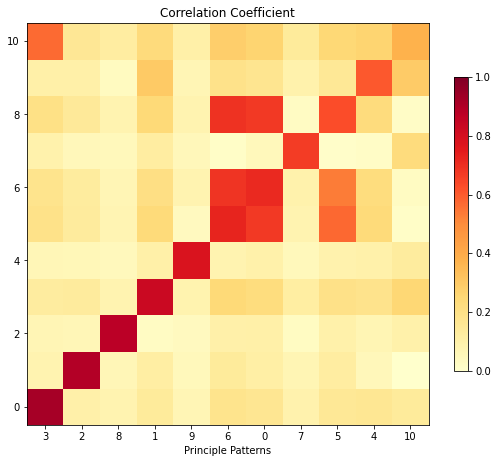

In [47]:
#DecGene PPs
corr_mat = correlation_map_with_CCF(PPs_3d,
                                    atlas_heatmap_DG,
                                    np.array(PPs_3d.shape),
                                    order_type=1,
                                    area_order=[3,2,8,1,9,6,0,7,5,4,10], # np.flip(np.argsort(max_corr_PP))
                                    put_last_k=0)

<Figure size 432x288 with 0 Axes>

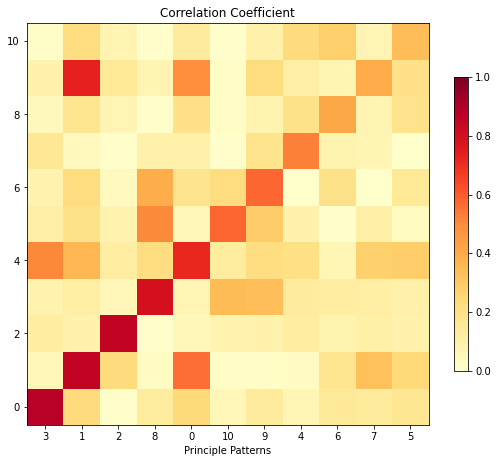

In [48]:
#PCA PPs
corr_mat_PCA = correlation_map_with_CCF(PPs_PCA_3d,
                                    atlas_heatmap_PCA,
                                    np.array(PPs_PCA_3d.shape),
                                    order_type=1,
                                    area_order=[3,1,2,8,0,10,9,4,6,7,5], # np.flip(np.argsort(max_corr_PP_PCA))
                                    put_last_k=0)

<Figure size 432x288 with 0 Axes>

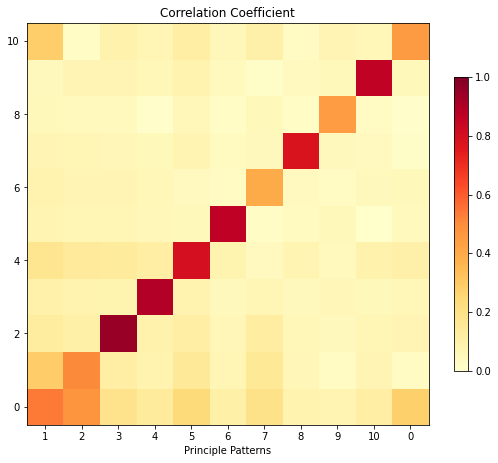

In [67]:
#PCA kmeans
corr_mat_PCA_kmeans = correlation_map_with_CCF(clusters_kmeans_PCA,
                                    atlas_heatmap_PCA_kmeans,
                                    np.array(clusters_kmeans_PCA.shape),
                                    order_type=1,
                                    area_order=[1,2,3,4,5,6,7,8,9,10,0],
                                    put_last_k=0)

<Figure size 432x288 with 0 Axes>

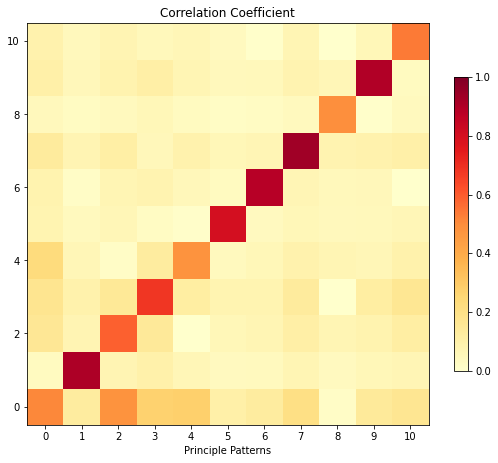

In [68]:
#PCA hier
corr_mat_PCA_hier = correlation_map_with_CCF(clusters_hier_PCA,
                                    atlas_heatmap_PCA_hier,
                                    np.array(clusters_hier_PCA.shape),
                                    order_type=2,
#                                     area_order=[3,1,2,8,0,9,10,4,7,6,5], # np.flip(np.argsort(max_corr_PP_PCA))
                                    put_last_k=0)

<Figure size 432x288 with 0 Axes>

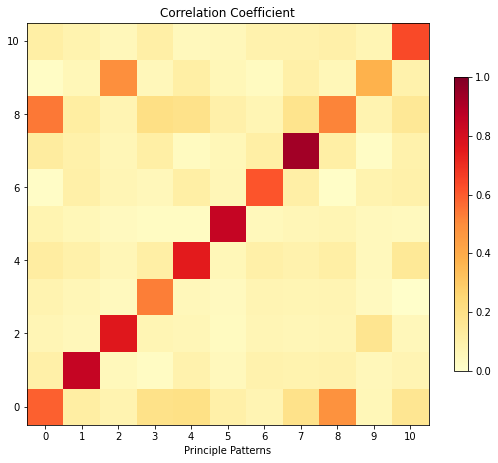

In [70]:
#DG hier
corr_mat_DG_hier = correlation_map_with_CCF(clusters_hier,
                                    atlas_heatmap_DG_hier,
                                    np.array(clusters_hier.shape),
                                    order_type=2,
#                                     area_order=[3,1,2,8,0,9,10,4,7,6,5], # np.flip(np.argsort(max_corr_PP_PCA))
                                    put_last_k=0)

<Figure size 432x288 with 0 Axes>

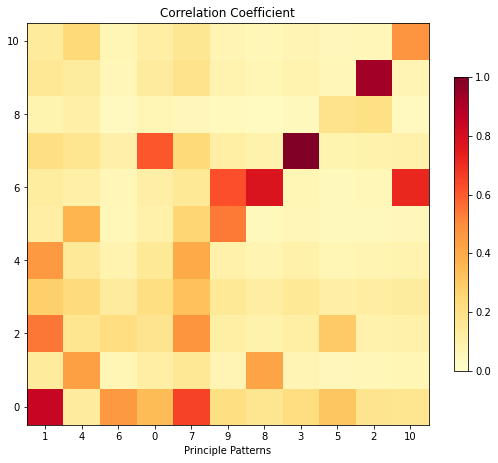

In [71]:
#Corr coeff of DG to PCA hier
corr_mat_tester = correlation_map_with_CCF(atlas_heatmap_PCA,
                                    atlas_heatmap_PCA_hier,
                                    np.array(clusters_hier.shape),
                                    order_type=1,
#                                     area_order=[9,4,3,1,2,8,0,10,7,6,5], # np.flip(np.argsort(max_corr_PP_PCA))
                                    put_last_k=0)

### isocortex exploration of PPs 1 (0), 6 (5), 7 (6)
**Fig. 4A** in manuscript

In [49]:
#slush for isocortex exploration

pps=[0,5,6]

# corr each ccf region to PP
corrs = []
for pp in pps:
    tmp_corrs = []
    for i in max_index_PP[pp]:
        tmp_corrs.append(np.corrcoef(PPs_3d[pp,support], ccf_fine_down[i,support])[0][1])
    tmp_corrs.sort(reverse=True)
    corrs.append(tmp_corrs)

corrs

[[0.7018490191674875, 0.06600395990742434, 0.06334718193602829],
 [0.5426576566288153, 0.1814770345599927, 0.1617386500445326],
 [0.6934057703821589, 0.12545587700417182, 0.08282800237342242]]

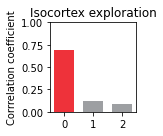

In [51]:
# bar plot of max PPs for each CCF region

from scipy.stats import sem


# Define labels, positions, bar heights and error bar heights
x_labels = ['Isocortex', 'Region1', 'Region 2']
x_pos = np.arange(len(x_labels))

# Build the plot
plt.figure(figsize=(2,2))
plt.bar(x_pos, corrs[2],
#        yerr=sems,
       width=.7,
       align='center',
       alpha=0.9,
       color=['#ED1C24', '#939598', '#939598'])
#        ecolor='white',
#        error_kw=dict(lw=1, capsize=5, capthick=1))
plt.ylabel('Corrrelation coefficient')
plt.ylim(0,1)
plt.xticks(x_pos)

plt.title('Isocortex exploration')
# plt.legend(x_labels)

# Save the figure and show
plt.tight_layout()
plt.savefig('../figures/isocortex_exploration.png', transparent=True)
plt.show()